In [1]:
%reload_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from importlib import reload 
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D

import topocalib
from topocalib.model import get_rotation
from topocalib.model_cv import ls_func, get_pixel_coordinates_test, array2params, get_pixel_coordinates

from topocalib.layout import show_layout

In [2]:
CHECKERBOARD = (6,19)
chess = np.zeros(shape=(CHECKERBOARD[0] * CHECKERBOARD[1], 3))
for i in range(CHECKERBOARD[0] * CHECKERBOARD[1]):
    chess[i] = np.array([ i % CHECKERBOARD[0], int(i / CHECKERBOARD[0]), 0])

multi_chess = np.concatenate((chess + np.array([0, 0, 2]), chess + np.array([0, 0, 5])), axis=0)
    

ks = [0.0, 0.0, 0.0]
C = [800]
center = [1400, 1400]
X_ws = [
    multi_chess,
    multi_chess,
    multi_chess,
    multi_chess
]
Ts = [
    np.array([-9.5, -5.7, 4]),
    np.array([-4, -6, 3]),
    np.array([-1, -1, 3]),
    np.array([0, -2, 3]),
]
Rs = [
    np.array([0.1, -0.2, -0.8]),
    np.array([0.1, -0.1, 0.3]),
    np.array([0.0, -0.0, 0.1]),
    np.array([0.0, -0.1, 0.1]),
]

X_cs = []


for X_w, T, R in zip(X_ws, Ts, Rs):
    arr = np.empty([0, 2])
    for point in X_w:
        px = get_pixel_coordinates(T, R, point, ks, C, center)
        arr = np.append(arr, np.transpose(px), axis=0)
    X_cs.append(arr)

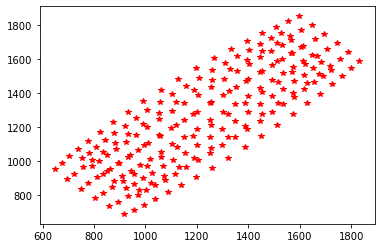

In [3]:
%matplotlib inline
plt.plot(X_cs[0][:, 0], X_cs[0][:, 1], 'r*', label='Ground truth')

In [9]:
# Show camera and points
%matplotlib widget

import cv2
from topocalib.model import get_rotation

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_ws[0][:, 0], X_ws[0][:, 1], X_ws[0][:, 2], label='Points')
colors = 'rrr'

image_i = 0
for T, R in zip(Ts, Rs):
    Xc1 = - np.array(T)
    
    for axis_i in range(3):
        axis = np.array([0, 0, 0])
        axis[axis_i] = 2
        
        Xc2 = axis * get_rotation(R).T + Xc1
        Xc2 = Xc2.A1
        print(Xc2)
        
        ax.plot(
            [Xc1[0], Xc2[0]], 
            [Xc1[1], Xc2[1]], 
            [Xc1[2], Xc2[2]],
            linewidth=2,
            color=colors[axis_i],
            label=('Camera #%s' % (image_i + 1)) if axis_i == 0 else None
        )
        ax.text(Xc2[0], Xc2[1], Xc2[2], 'XYZ'[axis_i])
    image_i += 1
    # ax.text(Xc1[0], Xc1[1], Xc1[2], 'Camera')
    
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_zlabel('Z coordinate')
ax.legend()

FigureCanvasNbAgg()

[10.86563792  4.24481867 -3.8677867 ]
[10.90611346  7.05799631 -3.57728145]
[ 9.10266134  5.50431321 -2.04965935]
[ 5.90112757  6.56904455 -2.75119836]
[ 3.41191233  7.9070183  -2.86796179]
[ 3.80033317  5.80133067 -1.01993342]
[ 2.99000833  1.19966683 -3.        ]
[ 0.80033317  2.99000833 -3.        ]
[ 1.  1. -1.]
[ 1.98006658  2.19966683 -2.80133067]
[-0.19866933  3.99000833 -3.01993342]
[-0.19966683  2.         -1.00999167]


In [32]:
T = [-10, -10, 0]
R = [0.0, 0.0, 0.0]
ks = [0.0, 0.0, 0.0]
C = [700]
center = [1400, 1400]


x0 = ks + C + center
rotation_translation_bounds = [[-np.inf, -np.inf, -np.inf, -np.pi, -np.pi, -np.pi],
             [np.inf, np.inf, np.inf, np.pi, np.pi, np.pi]]
bounds = [
    [-0.1, -0.1, -0.1, -np.inf, center[0] * 0.95, center[1] * 0.95],
    [0.1, 0.1, 0.1, np.inf, center[0] * 1.05, center[1] * 1.05] 
]

for objps, corners in zip(X_ws, X_cs):
    bounds[0] += rotation_translation_bounds[0]
    bounds[1] += rotation_translation_bounds[1]
    x0 += T + R

res = least_squares(ls_func, np.array(x0), bounds=tuple(bounds), args=(X_ws, X_cs), max_nfev=100)

jacobian = res.jac

#print(res)
K_all, D_all, R_all, T_all = array2params(res.x)
C = res.x[3]
center = res.x[4:6]
ks = res.x[0:3]
print(R_all)
print(T_all)
print(res.x)

[array([ 0.1, -0.2, -0.8]), array([ 0.1, -0.1,  0.3]), array([2.71265063e-17, 3.68840753e-17, 1.00000000e-01]), array([ 1.44396506e-16, -1.00000000e-01,  1.00000000e-01])]
[array([-9.5, -5.7,  4. ]), array([-4., -6.,  3.]), array([-1., -1.,  3.]), array([-5.43246004e-16, -2.00000000e+00,  3.00000000e+00])]
[ 2.78272933e-16 -2.47025102e-16  6.31097352e-17  8.00000000e+02
  1.40000000e+03  1.40000000e+03 -9.50000000e+00 -5.70000000e+00
  4.00000000e+00  1.00000000e-01 -2.00000000e-01 -8.00000000e-01
 -4.00000000e+00 -6.00000000e+00  3.00000000e+00  1.00000000e-01
 -1.00000000e-01  3.00000000e-01 -1.00000000e+00 -1.00000000e+00
  3.00000000e+00  2.71265063e-17  3.68840753e-17  1.00000000e-01
 -5.43246004e-16 -2.00000000e+00  3.00000000e+00  1.44396506e-16
 -1.00000000e-01  1.00000000e-01]


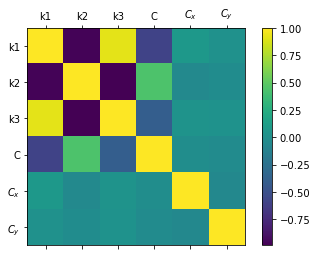

[[ 1.         -0.96562542  0.91724212 -0.58552434  0.07146016  0.01751113]
 [-0.96562542  1.         -0.9867748   0.44385294 -0.05313547 -0.02356281]
 [ 0.91724212 -0.9867748   1.         -0.39148373  0.03651525  0.02299968]
 [-0.58552434  0.44385294 -0.39148373  1.         -0.01127455 -0.02744389]
 [ 0.07146016 -0.05313547  0.03651525 -0.01127455  1.         -0.05634292]
 [ 0.01751113 -0.02356281  0.02299968 -0.02744389 -0.05634292  1.        ]]


In [33]:
%matplotlib inline

# Calaculate convariance matrix
cov = inv(np.transpose(jacobian) * np.matrix(jacobian))

# Normalise covariance matrix
nm = np.diag(np.power(np.diag(cov), -0.5))
corr = nm * cov * nm

# Visualise
names = ['', 'k1', 'k2', 'k3', 'C', '$C_x$', '$C_y$']
corr = corr[0:6, 0:6]
fig, ax = plt.subplots()
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
print(corr)

(228, 2)


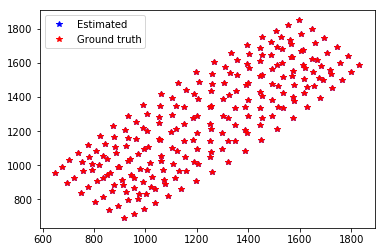

In [34]:
%matplotlib inline
IMG_ID = 0

estimated = np.empty([0, 2])
for point in X_ws[IMG_ID]:
    X_c = get_pixel_coordinates(T_all[IMG_ID], R_all[IMG_ID], point, ks, C, center)
    estimated = np.append(estimated, np.transpose(X_c), axis=0)
    

print(X_cs[IMG_ID].shape)
plt.plot(estimated[:, 0], estimated[:, 1], 'b*', label='Estimated')
plt.plot(X_cs[IMG_ID][:, 0], X_cs[IMG_ID][:, 1], 'r*', label='Ground truth')
plt.legend()

(array([112.,   0.,   0.,   0.,   0.,  21.,   0.,   7.,   0.,   0.,  65.,
         11.,   0.,   0.,   5.,   4.,   0.,   0.,   1.,   2.]),
 array([0.00000000e+00, 2.27373675e-14, 4.54747351e-14, 6.82121026e-14,
        9.09494702e-14, 1.13686838e-13, 1.36424205e-13, 1.59161573e-13,
        1.81898940e-13, 2.04636308e-13, 2.27373675e-13, 2.50111043e-13,
        2.72848411e-13, 2.95585778e-13, 3.18323146e-13, 3.41060513e-13,
        3.63797881e-13, 3.86535248e-13, 4.09272616e-13, 4.32009983e-13,
        4.54747351e-13]),
 <a list of 20 Patch objects>)

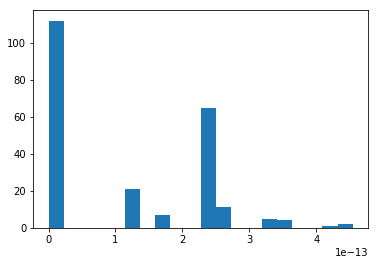

In [35]:
# Plot histogram of residuals

resid = X_cs[IMG_ID] - estimated
resid_dist = np.sqrt(resid[:, 0]**2 + resid[:, 1]**2)
plt.hist(resid_dist, bins=20)